This notebook is part of the `deepcell-tf` documentation: https://deepcell.readthedocs.io/.

# Training a segmentation model

`deepcell-tf` leverages [Jupyter Notebooks](https://jupyter.org) in order to train models. Example notebooks are available for most model architectures in the [notebooks folder](https://github.com/vanvalenlab/deepcell-tf/tree/master/notebooks). Most notebooks are structured similarly to this example and thus this notebook serves as a core reference for the deepcell approach to model training.

In [46]:
import os
import errno
import pandas as pd
import numpy as np
import glob
import statistics

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.segmentation import relabel_sequential
from skimage.transform import rescale, resize
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from IPython.display import HTML

import deepcell
from deepcell.utils.plot_utils import get_js_video
from deepcell.utils.utils_3D import get_3D_cell_statistics, load_mousebrain_data#, tile_predict_watershed
from deepcell_toolbox.deep_watershed import deep_watershed_3D
from deepcell_toolbox.utils import tile_image_3D, untile_image_3D

## Load data

In [ ]:
def load_mousebrain_data(filepath, set_nums, test_size=0.2, seed=0):
    X = []
    y = []

    for set_num in range(set_nums):
        path_to_folder = os.path.join(filepath, 'mov_{}'.format(set_num))

        for path_to_npz in glob.glob(os.path.join(path_to_folder, '*.npz')):
            with np.load(path_to_npz) as load_data:
                X.append(np.expand_dims(load_data['X'][..., 0], axis=-1))
                y.append(load_data['y'])

    X = np.asarray(X)
    y = np.asarray(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    return X_train, X_test, y_train, y_test

In [5]:
# Ask Geneva for help with this 

filepath = '/images/data/cells/MouseBrain/3D_annotations/attempt2'
set_nums = 4
test_size = 0.2
seed = 7

X_train, X_test, y_train, y_test = load_mousebrain_data(filepath, set_nums, test_size=test_size, seed=seed)
print('X_train.shape: {}\ty_train.shape: {}'.format(X_train.shape, y_train.shape))
print('X_test.shape: {}\ty_test.shape: {}'.format(X_test.shape, y_test.shape))

#small_objects_threshold = 50

# remove small objects - there are some incorrect annotations of very small cells. Should consider removing before training.
#for i in range(y_train.shape[0]):
#    y_train[i] = remove_small_objects(y_train[i].astype(int), min_size=small_objects_threshold)
    
#for i in range(y_test.shape[0]):
#    y_train[i] = remove_small_objects(y_test[i].astype(int), min_size=small_objects_threshold)

X_train.shape: (11, 47, 512, 512, 1)	y_train.shape: (11, 47, 512, 512, 1)
X_test.shape: (3, 47, 512, 512, 1)	y_test.shape: (3, 47, 512, 512, 1)


## Set up filepath constants


In [6]:
# Ask Dylan about setting up Docker and what to do about file paths here (can also ask Geneva)

filename = '--.npz'

DATA_DIR = os.path.expanduser(os.path.join(filepath))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

# save models on madrox
ROOT_DIR = '/deepcell_data'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## View cell statistics

In [4]:
stats = get_3D_cell_statistics(np.concatenate((y_train, y_test), axis=0))

print('Cell dimensions: mean x is {}, mean y is {}, and mean z is {}'.format(
    stats['x_mean'], stats['y_mean'], stats['z_mean']))

Cell dimensions: mean x is 36.97, mean y is 38.69, and mean z is 16.25


In [18]:
"""Semantic segmentation data generators."""

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os

import numpy as np
from skimage.transform import rescale, resize

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import array_to_img
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.platform import tf_logging as logging

try:
    import scipy
    # scipy.linalg cannot be accessed until explicitly imported
    from scipy import linalg
    # scipy.ndimage cannot be accessed until explicitly imported
    from scipy import ndimage
except ImportError:
    scipy = None

from deepcell.image_generators import _transform_masks

class Semantic3DIterator(Iterator):
    """Iterator yielding data from Numpy arrays (X and y).

    Args:
        train_dict (dict): Dictionary consisting of numpy arrays for X and y.
        3d_data_generator (Semantic3DGenerator): Semantic3DGenerator
            to use for random transformations and normalization.
        batch_size (int): Size of a batch.
        frames_per_batch (int): Size of z axis in generated batches.
        shuffle (boolean): Whether to shuffle the data between epochs.
        seed (int): Random seed for data shuffling.
        min_objects (int): Minumum number of objects allowed per image.
        data_format (str): One of 'channels_first', 'channels_last'.
        save_to_dir (str): Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix (str): Prefix to use for saving sample
            images (if save_to_dir is set).
        save_format (str): Format to use for saving sample images
            (if save_to_dir is set).
    """

    def __init__(self,
                 train_dict,
                 data_generator_3d,
                 batch_size=1,
                 frames_per_batch=5,
                 frame_shape=None,
                 shuffle=False,
                 transforms=['outer-distance'],
                 transforms_kwargs={},
                 aug_3d=False,
                 rotation_3d=0,
                 sampling=None,
                 z_scale=None,
                 seed=None,
                 min_objects=3,
                 data_format='channels_last',
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):

        # Load data
        if 'X' not in train_dict:
            raise ValueError('No training data found in train_dict')

        if 'y' not in train_dict:
            raise ValueError('Instance masks are required for the '
                             'Semantic3DIterator')

        X, y = train_dict['X'], train_dict['y']

        if X.shape[0] != y.shape[0]:
            raise ValueError('Training batches and labels should have the same'
                             'length. Found X.shape: {} y.shape: {}'.format(
                                 X.shape, y.shape))

        if X.ndim != 5:
            raise ValueError('Input data in `Semantic3DIterator` '
                             'should have rank 5. You passed an array '
                             'with shape', X.shape)

        if rotation_3d > 0 and not z_scale:
            raise ValueError('z_scaling factor required to rotate in 3d')

        def _scale_im(input_im, scale, order):

            dtype = input_im.dtype
            batch_list = []
            for batch_num in range(input_im.shape[0]):
                batch = input_im[batch_num, ...]

                if data_format == 'channels_first':

                    batch = np.moveaxis(batch, 0, -1)
                    rescaled = rescale(batch, scale, order=order, preserve_range=True, multichannel=True)
                    rescaled = np.moveaxis(rescaled, -1, 0)

                else:
                    rescaled = rescale(batch, scale, order=order, preserve_range=True, multichannel=True)


                batch_list.append(rescaled)
            return np.stack(batch_list, axis=0).astype(dtype)

        if aug_3d and rotation_3d > 0:
            scale = tuple([z_scale, 1, 1])
            X = _scale_im(X, scale, order=1)
            y = _scale_im(y, scale, order=0)

            self.output_frames = frames_per_batch
            frames_per_batch = round(frames_per_batch * z_scale)


        self.x = np.asarray(X, dtype=K.floatx())
        self.y = np.asarray(y, dtype='int32')
        self.frames_per_batch = frames_per_batch
        self.frame_shape = frame_shape
        self.transforms = transforms
        self.transforms_kwargs = transforms_kwargs
        self.aug_3d = aug_3d
        self.rotation_3d = rotation_3d
        self.z_scale = z_scale
        self.channel_axis = 4 if data_format == 'channels_last' else 1
        self.time_axis = 1 if data_format == 'channels_last' else 2
        self.row_axis = 2 if data_format == 'channels_last' else 3
        self.col_axis = 3 if data_format == 'channels_last' else 4
        self.data_generator_3d = data_generator_3d
        self.data_format = data_format
        self.min_objects = min_objects
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        self.y_semantic_list = []  # optional semantic segmentation targets

        if X.shape[self.time_axis] - frames_per_batch < 0:
            raise ValueError(
                'The number of frames used in each training batch should '
                'be less than the number of frames in the training data!'
                'fpb is {} and timeaxis is {}'.format(frames_per_batch, X.shape[self.time_axis]))

        # Create a list of all the semantic targets. We need to be able
        # to have multiple semantic heads
        # Add all the keys that contain y_semantic
        # Add transformed masks
        for transform in transforms:
            transform_kwargs = transforms_kwargs.get(transform, dict())
            y_transform = _transform_masks(y, transform,
                                           data_format=data_format,
                                           **transform_kwargs)
            if y_transform.shape[self.channel_axis] > 1:
                y_transform = np.asarray(y_transform, dtype='int32')
            elif y_transform.shape[self.channel_axis] == 1:
                y_transform = np.asarray(y_transform, dtype=K.floatx())
            self.y_semantic_list.append(y_transform)

        invalid_batches = []

        # Remove images with small numbers of cells
        # TODO: make this work with the cropping implementation
        for b in range(self.x.shape[0]):
            if len(np.unique(self.y[b])) - 1 < self.min_objects:
                invalid_batches.append(b)

        invalid_batches = np.array(invalid_batches, dtype='int')

        if invalid_batches.size > 0:
            logging.warning('Removing %s of %s images with fewer than %s '
                            'objects.', invalid_batches.size, self.x.shape[0],
                            self.min_objects)

        self.x = np.delete(self.x, invalid_batches, axis=0)
        self.y = np.delete(self.y, invalid_batches, axis=0)
        self.y_semantic_list = [np.delete(y, invalid_batches, axis=0)
                                for y in self.y_semantic_list]

        super(Semantic3DIterator, self).__init__(
            self.x.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):

        if self.frame_shape:
            if self.data_format == 'channels_first':
                batch_x = np.zeros((len(index_array),
                                    self.x.shape[1],
                                    self.frames_per_batch,
                                    self.frame_shape[0],
                                    self.frame_shape[1]))
            else:
                batch_x = np.zeros((len(index_array),
                                    self.frames_per_batch,
                                    self.frame_shape[0],
                                    self.frame_shape[1],
                                    self.x.shape[4]))

            if self.data_format == 'channels_first':
                batch_y_semantic_list = [np.zeros(tuple([len(index_array),
                                                         y_semantic.shape[1],
                                                         self.frames_per_batch,
                                                         self.frame_shape[0],
                                                         self.frame_shape[1]]))
                                         for y_semantic in self.y_semantic_list]
            else:
                batch_y_semantic_list = [
                    np.zeros((len(index_array),
                                    self.frames_per_batch,
                                    self.frame_shape[0],
                                    self.frame_shape[1],
                                    y_semantic.shape[4]))
                    for y_semantic in self.y_semantic_list
                ]

        else:
            if self.data_format == 'channels_first':
                batch_x = np.zeros((len(index_array),
                                    self.x.shape[1],
                                    self.frames_per_batch,
                                    self.x.shape[3],
                                    self.x.shape[4]))
            else:
                batch_x = np.zeros(tuple([len(index_array),
                                         self.frames_per_batch] +
                                         list(self.x.shape)[2:]))

            if self.data_format == 'channels_first':
                batch_y_semantic_list = [np.zeros(tuple([len(index_array),
                                                         y_semantic.shape[1],
                                                         self.frames_per_batch,
                                                         y_semantic.shape[3],
                                                         y_semantic.shape[4]]))
                                         for y_semantic in self.y_semantic_list]
            else:
                batch_y_semantic_list = [
                    np.zeros(tuple([len(index_array), self.frames_per_batch] +
                                   list(y_semantic.shape[2:])))
                    for y_semantic in self.y_semantic_list
                ]

        for i, j in enumerate(index_array):
            last_frame = self.x.shape[self.time_axis] - self.frames_per_batch

            if last_frame == 0:
                time_start = 0
            else:
                time_start = np.random.randint(0, high=last_frame)

            time_end = time_start + self.frames_per_batch

            if self.frame_shape:
                last_row = self.x.shape[self.row_axis] - self.frame_shape[0]
                last_col = self.x.shape[self.col_axis] - self.frame_shape[1]

                if last_row == 0:
                    row_start = 0
                else:
                    row_start = np.random.randint(0, high=last_row)

                if last_col == 0:
                    col_start = 0
                else:
                    col_start = np.random.randint(0, high=last_col)

                row_end = row_start + self.frame_shape[0]
                col_end = col_start + self.frame_shape[1]

                if self.time_axis == 1:
                    x = np.copy(self.x[j, time_start:time_end, row_start:row_end, col_start:col_end, :])
                    y = np.copy(self.y[j, time_start:time_end, row_start:row_end, col_start:col_end, :])
                elif self.time_axis == 2:
                    x = np.copy(self.x[j, :, time_start:time_end, row_start:row_end, col_start:col_end])
                    y = np.copy(self.y[j, :, time_start:time_end, row_start:row_end, col_start:col_end])

                if self.time_axis == 1:
                    y_semantic_list = [np.copy(y_semantic[j, time_start:time_end, row_start:row_end, col_start:col_end, :])
                                       for y_semantic in self.y_semantic_list]
                elif self.time_axis == 2:
                    y_semantic_list = [np.copy(y_semantic[j, :, time_start:time_end, row_start:row_end, col_start:col_end])
                                       for y_semantic in self.y_semantic_list]

            else:
                if self.time_axis == 1:
                    x = self.x[j, time_start:time_end, ...]
                    y = self.y[j, time_start:time_end, ...]
                elif self.time_axis == 2:
                    x = self.x[j, :, time_start:time_end, ...]
                    y = self.y[j, :, time_start:time_end, ...]

                if self.time_axis == 1:
                    y_semantic_list = [y_semantic[j, time_start:time_end, ...]
                                       for y_semantic in self.y_semantic_list]
                elif self.time_axis == 2:
                    y_semantic_list = [y_semantic[j, :, time_start:time_end, ...]
                                       for y_semantic in self.y_semantic_list]

            # Apply transformation
            x, y_list = self.data_generator_3d.random_transform(x,
                                                                [y] + y_semantic_list,
                                                                aug_3d=self.aug_3d,
                                                                rotation_3d=self.rotation_3d)
            y = y_list[0]
            y_semantic_list = y_list[1:]

            x = self.data_generator_3d.standardize(x)

            batch_x[i] = x

            for k, y_sem in enumerate(y_semantic_list):
                batch_y_semantic_list[k][i] = y_sem

            batch_y = batch_y_semantic_list

            if self.save_to_dir:
                time_axis = 2 if self.data_format == 'channels_first' else 1
                for i, j in enumerate(index_array):
                    for frame in range(batch_x.shape[time_axis]):
                        if time_axis == 2:
                            img = array_to_img(batch_x[i, :, frame],
                                               self.data_format, scale=True)
                        else:
                            img = array_to_img(batch_x[i, frame],
                                               self.data_format, scale=True)
                        fname = '{prefix}_{index}_{hash}.{format}'.format(
                            prefix=self.save_prefix,
                            index=j,
                            hash=np.random.randint(1e4),
                            format=self.save_format)
                        img.save(os.path.join(self.save_to_dir, fname))

                        if self.y is not None:
                            # Save argmax of y batch
                            if self.time_axis == 2:
                                img_y = np.argmax(batch_y[0][i, :, frame],
                                                  axis=0)
                                img_channel_axis = 0
                                img_y = batch_y[0][i, :, frame]
                            else:
                                img_channel_axis = -1
                                img_y = batch_y[0][i, frame]
                            img_y = np.argmax(img_y, axis=img_channel_axis)
                            img_y = np.expand_dims(img_y,
                                                   axis=img_channel_axis)
                            img = array_to_img(img_y, self.data_format,
                                               scale=True)
                            fname = 'y_{prefix}_{index}_{hash}.{format}'.format(
                                prefix=self.save_prefix,
                                index=j,
                                hash=np.random.randint(1e4),
                                format=self.save_format)
                            img.save(os.path.join(self.save_to_dir, fname))

        def _resize_im(input_im, shape, order):
            dtype = input_im.dtype
            batch_list = []
            for batch_num in range(input_im.shape[0]):
                batch = input_im[batch_num, ...]

                if self.data_format == 'channels_first':

                    batch = np.moveaxis(batch, 0, -1)
                    resized = resize(batch, shape, order=order, preserve_range=True)
                    resized = np.moveaxis(resized, -1, 0)

                    if resized.shape[0] > 1:
                        resized = np.around(resized, decimals=0)

                else:
                    resized = resize(batch, shape, order=order, preserve_range=True)

                    if resized.shape[-1] > 1:
                        resized = np.around(resized, decimals=0)




                batch_list.append(resized)
            return np.stack(batch_list, axis=0).astype(dtype)


        if self.aug_3d and self.rotation_3d > 0:
            scale = tuple([1/self.z_scale, 1, 1])
            out_shape = tuple([self.output_frames, self.frame_shape[0], self.frame_shape[1]])

            batch_x = _resize_im(batch_x, out_shape, order=1)

            for y in range(len(batch_y)):
                batch_y[y] = _resize_im(batch_y[y], out_shape, order=0)

        return batch_x, batch_y


    def next(self):
        """For python 2.x. Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)


class Semantic3DGenerator(ImageDataGenerator):
    """Generates batches of tensor image data with real-time data augmentation.
    The data will be looped over (in batches).

    Args:
        featurewise_center (bool): Set input mean to 0 over the dataset,
            feature-wise.
        samplewise_center (bool): Set each sample mean to 0.
        featurewise_std_normalization (bool): Divide inputs by std
            of the dataset, feature-wise.
        samplewise_std_normalization (bool): Divide each input by its std.
        zca_epsilon (float): Epsilon for ZCA whitening. Default is 1e-6.
        zca_whitening (bool): Apply ZCA whitening.
        rotation_range (int): Degree range for random rotations.
        width_shift_range (float): 1-D array-like or int

            - float: fraction of total width, if < 1, or pixels if >= 1.
            - 1-D array-like: random elements from the array.
            - int: integer number of pixels from interval
              (-width_shift_range, +width_shift_range)
            - With width_shift_range=2 possible values are ints [-1, 0, +1],
              same as with width_shift_range=[-1, 0, +1], while with
              width_shift_range=1.0 possible values are floats in the interval
              [-1.0, +1.0).

        shear_range (float): Shear Intensity
            (Shear angle in counter-clockwise direction in degrees)
        zoom_range (float): float or [lower, upper], Range for random zoom.
            If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
        channel_shift_range (float): range for random channel shifts.
        fill_mode (str): One of {"constant", "nearest", "reflect" or "wrap"}.

            Default is 'nearest'. Points outside the boundaries of the input
            are filled according to the given mode:

                - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                - 'nearest':  aaaaaaaa|abcd|dddddddd
                - 'reflect':  abcddcba|abcd|dcbaabcd
                - 'wrap':  abcdabcd|abcd|abcdabcd

        cval (float): Value used for points outside the boundaries
            when fill_mode = "constant".
        horizontal_flip (bool): Randomly flip inputs horizontally.
        vertical_flip (bool): Randomly flip inputs vertically.
        rescale (float): rescaling factor. Defaults to None. If None or 0, no
            rescaling is applied, otherwise we multiply the data by the value
            provided (before applying any other transformation).
        preprocessing_function (function): function that will be implied on
            each input.
            The function will run after the image is resized and augmented.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format (str): One of {"channels_first", "channels_last"}.

            - "channels_last" mode means that the images should have shape
              (samples, height, width, channels),
            - "channels_first" mode means that the images should have shape
              (samples, channels, height, width).
            - It defaults to the image_data_format value found in your
              Keras config file at "~/.keras/keras.json".
            - If you never set it, then it will be "channels_last".

        validation_split (float): Fraction of images reserved for validation
            (strictly between 0 and 1).
    """
    def __init__(self, **kwargs):
        super(Semantic3DGenerator, self).__init__(**kwargs)
        # Change the axes for 5D data
        if self.data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 3
            self.col_axis = 4
            self.time_axis = 2
        if self.data_format == 'channels_last':
            self.channel_axis = 4
            self.row_axis = 2
            self.col_axis = 3
            self.time_axis = 1

    def flow(self,
             train_dict,
             batch_size=1,
             frames_per_batch=5,
             frame_shape=None,
             transforms=['outer-distance'],
             transforms_kwargs={},
             aug_3d=False,
             rotation_3d=0,
             z_scale=None,
             shuffle=True,
             min_objects=3,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
        """Generates batches of augmented/normalized data with given arrays.

        Args:
            train_dict (dict): Consists of numpy arrays for X and y.
            batch_size (int): Size of a batch.
            frames_per_batch (int): Size of z axis in generated batches.
            shuffle (bool): Whether to shuffle the data between epochs.
            seed (int): Random seed for data shuffling.
            min_objects (int): Images with fewer than 'min_objects' are ignored.
            save_to_dir (str): Optional directory where to save the pictures
                being yielded, in a viewable format. This is useful
                for visualizing the random transformations being
                applied, for debugging purposes.
            save_prefix (str): Prefix to use for saving sample
                images (if save_to_dir is set).
            save_format (str): Format to use for saving sample images
                (if save_to_dir is set).

        Returns:
            Semantic3DIterator: An Iterator yielding tuples of (x, y)
                where x is a numpy array of image data and y is a list of
                numpy arrays of transformed masks.
        """
        return Semantic3DIterator(
            train_dict,
            self,
            batch_size=batch_size,
            frames_per_batch=frames_per_batch,
            frame_shape=frame_shape,
            transforms=transforms,
            transforms_kwargs=transforms_kwargs,
            aug_3d=aug_3d,
            rotation_3d=rotation_3d,
            z_scale=z_scale,
            shuffle=shuffle,
            min_objects=min_objects,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)


    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.

        Args:
            x (numpy.array): batch of inputs to be normalized.

        Returns:
            numpy.array: The normalized inputs.
        """
        # TODO: standardize each image, not all frames at once
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_axis = self.channel_axis - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_axis, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_axis, keepdims=True) +
                  K.epsilon())

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                logging.warning('This ImageDataGenerator specifies '
                                '`featurewise_std_normalization`, but it '
                                'hasn\'t been fit on any training data. '
                                'Fit it first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + K.epsilon())
            else:
                logging.warning('This ImageDataGenerator specifies '
                                '`featurewise_std_normalization`, but it '
                                'hasn\'t been fit on any training data. Fit '
                                'it first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, x.shape)
            else:
                logging.warning('This ImageDataGenerator specifies '
                                '`zca_whitening`, but it hasn\'t '
                                'been fit on any training data. Fit it '
                                'first by calling `.fit(numpy_data)`.')
        return x

    def fit(self, x, augment=False, rounds=1, seed=None):
        """Fits internal statistics to some sample data.
        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        Args:
            x (numpy.array): The data to fit on. Should have rank 5.
            augment (bool): Whether to fit on randomly augmented samples.
            rounds (bool): If augment,
                how many augmentation passes to do over the data.
            seed (int): Random seed for data shuffling.
        Raises:
            ValueError: If input rank is not 5.
            ImportError: If zca_whitening is used and scipy is not available.
        """
        x = np.asarray(x, dtype=self.dtype)
        if x.ndim != 5:
            raise ValueError('Input to `.fit()` should have rank 5. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            logging.warning(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' +
                self.data_format + '" (channels on axis ' +
                str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' +
                str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' +
                str(x.shape) + ' (' + str(x.shape[self.channel_axis]) +
                ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(
                tuple([rounds * x.shape[0]] + list(x.shape)[1:]),
                dtype=self.dtype)
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            axis = (0, self.time_axis, self.row_axis, self.col_axis)
            self.mean = np.mean(x, axis=axis)
            broadcast_shape = [1, 1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            axis = (0, self.time_axis, self.row_axis, self.col_axis)
            self.std = np.std(x, axis=axis)
            broadcast_shape = [1, 1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            if scipy is None:
                raise ImportError('Using zca_whitening requires SciPy. '
                                  'Install SciPy.')
            flat_x = np.reshape(
                x, (x.shape[0],
                    x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = scipy.linalg.svd(sigma)
            s_inv = 1. / np.sqrt(s[np.newaxis] + self.zca_epsilon)
            self.principal_components = (u * s_inv).dot(u.T)

    def random_transform(self, x, y=None, seed=None, aug_3d=False, rotation_3d=0):
        """Applies a random transformation to an image.

        Args:
            x (numpy.array): 4D tensor or list of 4D tensors.
            y (numpy.array): 4D tensor or list of 4D tensors,
                label mask(s) for x, optional.
            seed (int): Random seed.

        Returns:
            numpy.array: A randomly transformed copy of the input (same shape).
                If y is passed, it is transformed if necessary and returned.
        """
        self.row_axis -= 1
        self.col_axis -= 1
        self.time_axis -= 1
        self.channel_axis -= 1

        if isinstance(x, list):
            params = self.get_random_transform(x[0].shape, seed)
        else:
            params = self.get_random_transform(x.shape, seed)

        if aug_3d:
            
            # Don't want to brighten or zoom multiple times
            _brightness_range = self.brightness_range
            _zoom_range = self.zoom_range
            self.brightness_range = None
            self.zoom_range = (1, 1)
            
            # Set params for 3d_augmentation with rotation set to 0
            # Compatible with anisotropic data (with sampling not 1:1:1)
            if rotation_3d == 0:    
                _rotation_range = self.rotation_range
                self.rotation_range = 0

                if isinstance(x, list):
                    params_3d = self.get_random_transform(np.moveaxis(x[0], 0, 1).shape, seed)
                else:
                    params_3d = self.get_random_transform(np.moveaxis(x, 0, 1).shape, seed)

                self.rotation_range = _rotation_range
        
            # Set params for full 3d_augmentation - requires sampling with a ratio of 1:1:1
            else:
                _rotation_range = self.rotation_range
                self.rotation_range = self.rotation_3d
                
                if isinstance(x, list):
                    params_3d = self.get_random_transform(np.moveaxis(x[0], 0, 1).shape, seed)
                else:
                    params_3d = self.get_random_transform(np.moveaxis(x, 0, 1).shape, seed)
                
                self.rotation_range = _rotation_range
                
            self.brightness_range = _brightness_range
            self.zoom_range = _zoom_range
            
        if isinstance(x, list):
            for i in range(len(x)):
                x_i = x[i]
                for frame in range(x_i.shape[self.time_axis]):
                    if self.data_format == 'channels_first':
                        x_trans = self.apply_transform(x_i[:, frame], params)
                        x_i[:, frame] = np.rollaxis(x_trans, -1, 0)
                    else:
                        x_i[frame] = self.apply_transform(x_i[frame], params)
                x[i] = x_i
        else:
            for frame in range(x.shape[self.time_axis]):
                if self.data_format == 'channels_first':
                    x_trans = self.apply_transform(x[:, frame], params)
                    x[:, frame] = np.rollaxis(x_trans, -1, 0)
                else:
                    temp = self.apply_transform(x[frame], params)
                    x[frame] = self.apply_transform(x[frame], params)

        if aug_3d:
            if isinstance(x, list):
                for i in range(len(x)):
                    x_i = x[i]
                    for frame in range(x_i.shape[self.row_axis]):
                        if self.data_format == 'channels_first':
                            x_trans = self.apply_transform(x_i[:, :, frame], params_3d)
                            x_i[:, :, frame] = np.rollaxis(x_trans, -1, 0)
                        else:
                            x_i[:, frame] = self.apply_transform(x_i[:, frame], params_3d)

                    for frame in range(x_i.shape[self.col_axis]):
                        if self.data_format == 'channels_first':
                            x_trans = self.apply_transform(x_i[..., frame], params_3d)
                            x_i[..., frame] = np.rollaxis(x_trans, -1, 0)
                        else:
                            x_i[:, :, frame] = self.apply_transform(x_i[:, :, frame], params_3d)
                    x[i] = x_i
            else:

                for frame in range(x.shape[self.row_axis]):
                    if self.data_format == 'channels_first':
                        x_trans = self.apply_transform(x[:, :, frame], params_3d)
                        x[:, :, frame] = np.rollaxis(x_trans, -1, 0)
                    else:
                        temp = self.apply_transform(x[:, frame], params_3d)
                        x[:, frame] = self.apply_transform(x[:, frame], params_3d)

                for frame in range(x.shape[self.col_axis]):
                    if self.data_format == 'channels_first':
                        x_trans = self.apply_transform(x[..., frame], params_3d)
                        x[..., frame] = np.rollaxis(x_trans, -1, 0)
                    else:
                        temp = self.apply_transform(x[:, :, frame], params_3d)
                        x[:, :, frame] = self.apply_transform(x[:, :, frame], params_3d)


        if y is not None:
            params['brightness'] = None
            params['channel_shift_intensity'] = None

            _interpolation_order = self.interpolation_order

            if isinstance(y, list):
                for i in range(len(y)):
                    y_i = y[i]

                    if y_i.shape[self.channel_axis] > 1:
                        self.interpolation_order = 0
                    else:
                        self.interpolation_order = _interpolation_order

                    for frame in range(y_i.shape[self.time_axis]):
                        if self.data_format == 'channels_first':
                            y_trans = self.apply_transform(y_i[:, frame],
                                                           params)
                            y_i[:, frame] = np.rollaxis(y_trans, 1, 0)
                        else:
                            y_i[frame] = self.apply_transform(y_i[frame],
                                                              params)

                    y[i] = y_i

                    self.interpolation_order = _interpolation_order

            else:
                if y.shape[self.channel_axis] > 1:
                    self.interpolation_order = 0
                else:
                    self.interpolation_order = _interpolation_order

                for frame in range(y.shape[self.time_axis]):
                    if self.data_format == 'channels_first':
                        y_trans = self.apply_transform(y[:, frame], params)
                        y[:, frame] = np.rollaxis(y_trans, 1, 0)
                    else:
                        y[frame] = self.apply_transform(y[frame], params)

                self.interpolation_order = _interpolation_order

            # Augment masks in 3D
            if aug_3d:
                _interpolation_order = self.interpolation_order

                if isinstance(y, list):
                    for i in range(len(y)):
                        y_i = y[i]

                        if y_i.shape[self.channel_axis] > 1:
                            self.interpolation_order = 0
                        else:
                            self.interpolation_order = _interpolation_order

                        for frame in range(y_i.shape[self.row_axis]):
                            if self.data_format == 'channels_first':
                                y_trans = self.apply_transform(y_i[:, :, frame],
                                                               params_3d)
                                y_i[:, :, frame] = np.moveaxis(y_trans, -1, 0)
                            else:
                                y_i[:, frame] = self.apply_transform(y_i[:, frame],
                                                                  params_3d)
                        for frame in range(y_i.shape[self.col_axis]):
                            if self.data_format == 'channels_first':
                                y_trans = self.apply_transform(y_i[..., frame],
                                                               params_3d)
                                y_i[..., frame] = np.moveaxis(y_trans, -1, 0)
                            else:
                                y_i[:, :, frame] = self.apply_transform(y_i[:, :, frame],
                                                                  params_3d)
                        y[i] = y_i

                        self.interpolation_order = _interpolation_order

                else:
                    if y.shape[self.channel_axis] > 1:
                        self.interpolation_order = 0
                    else:
                        self.interpolation_order = _interpolation_order

                    for frame in range(y.shape[self.row_axis]):
                        if self.data_format == 'channels_first':
                            y_trans = self.apply_transform(y[:, :, frame], params_3d)
                            y[:, :, frame] = np.rollaxis(y_trans, 1, 0)
                        else:
                            y[:, frame] = self.apply_transform(y[:, frame], params_3d)

                    for frame in range(y.shape[self.col_axis]):
                        if self.data_format == 'channels_first':
                            y_trans = self.apply_transform(y[..., frame], params_3d)
                            y[..., frame] = np.rollaxis(y_trans, 1, 0)
                        else:
                            y[:, :, frame] = self.apply_transform(y[:, :, frame], params_3d)

                    self.interpolation_order = _interpolation_order


        # Note: Undo workaround
        self.row_axis += 1
        self.col_axis += 1
        self.time_axis += 1
        self.channel_axis += 1

        if y is None:
            return x

        return x, y


In [44]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import skimage as sk

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import array_to_img
from tensorflow.python.keras.preprocessing.image import img_to_array
from tensorflow.python.platform import test


def _generate_test_images(img_w=21, img_h=21):
    rgb_images = []
    gray_images = []
    for _ in range(8):
        bias = np.random.rand(img_w, img_h, 1) * 64
        variance = np.random.rand(img_w, img_h, 1) * (255 - 64)
        imarray = np.random.rand(img_w, img_h, 3) * variance + bias
        im = array_to_img(imarray, scale=False)
        rgb_images.append(im)

        imarray = np.random.rand(img_w, img_h, 1) * variance + bias
        im = array_to_img(imarray, scale=False)
        gray_images.append(im)

    return [rgb_images, gray_images]


class TestSemantic3DGenerator(test.TestCase):

    def test_semantic_3d_generator_channels_first(self):
        frames = 7
        frames_per_batch = 5
        frame_shape = (12, 12, 1)
        output_shape = (frames_per_batch, frame_shape[0], frame_shape[1])
        aug_3d = True
        rotation_3d = 0

        for test_images in _generate_test_images(21, 21):
            img_list = []
            for im in test_images:
                frame_list = []
                for _ in range(frames):
                    frame_list.append(img_to_array(im)[None, ...])
                img_stack = np.vstack(frame_list)
                img_list.append(img_stack)

            images = np.vstack(img_list)
            batch_count = images.shape[0] // frames
            images = np.reshape(images, tuple([batch_count, frames] +
                                              list(images.shape[1:])))
            images = np.rollaxis(images, 4, 1)
            generator = Semantic3DGenerator(
                featurewise_center=True,
                samplewise_center=True,
                featurewise_std_normalization=True,
                samplewise_std_normalization=True,
                zca_whitening=False,
                rotation_range=90.,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.5,
                zoom_range=0.2,
                channel_shift_range=1.,
                # brightness_range=(1, 5),  # TODO: `channels_first` conflict
                fill_mode='nearest',
                cval=0.5,
                horizontal_flip=True,
                vertical_flip=True,
                data_format='channels_first')

            # Basic test before fit
            train_dict = {
                'X': np.random.random((8, 3, 11, 10, 10)),
                'y': np.random.random((8, 1, 11, 10, 10)),
            }
            generator.flow(train_dict)

            # Temp dir to save generated images
            temp_dir = self.get_temp_dir()

            # Fit
            generator.fit(images, augment=True, seed=1)
            batch_x_shape = tuple([images.shape[1], frames_per_batch] +
                                  list(images.shape[3:]))
            y_shape = tuple([images.shape[0], 1] + list(images.shape)[2:])
            train_dict['X'] = images
            train_dict['y'] = np.random.randint(0, 9, size=y_shape)
            transforms = ['outer-distance', 'fgbg']
            for x, y in generator.flow(
                    train_dict,
                    frames_per_batch=frames_per_batch,
                    transforms=transforms,
                    frame_shape=frame_shape,
                    aug_3d=aug_3d,
                    rotation_3d=rotation_3d,
                    save_to_dir=temp_dir,
                    shuffle=True):
                self.assertEqual(x.shape[1:], (x.shape[1],) + output_shape)
                self.assertEqual(len(y), len(transforms))
                break

In [45]:
test = TestSemantic3DGenerator()

test.test_semantic_3d_generator_channels_first()

W0807 03:27:38.832900 140312332773184 <ipython-input-18-da30da660ee6>:180] Removing 8 of 8 images with fewer than 3 objects.
W0807 03:27:39.307019 140312332773184 <ipython-input-18-da30da660ee6>:180] Removing 8 of 8 images with fewer than 3 objects.


## Prepare data

### Set up input and augmentation parameters
**model_name**: Incorporated into any files generated during the training process.

**frame_shape**: Defines the x & y dimensions of the model input. They must be equivalent powers of 2. A good starting point is to set this as the smallest power of 2 that is greater than the mean x & y dimensions. 

**frames_per_batch**: Defines the z dimensions of the model input. Can be any integer ranging from 1 to the max height of the data. A good starting point is to set this as just greater than the mean cell height. 

**aug_3d**: Whether or not to perform 3d spatial data augmentation. With just this flag on, the only augmentation performed in 3d is flipping. It is recommended to leave this on for all 3d data. 

**rotation_3d**: Choose the range in degrees for rotation in 3d (rotating the xz and yz planes in addition to xy). Highly recommended to start out leaving this at 0. Can experiment with increasing this - if so, I would recommend staying within the range of 1-15. Larger rotation ranges result in significant clipping out of data. It should also be noted that using 3d_rotation *significantly* slows down training, as each batch is individually scaled down before being returned. 

**sampling**: The pixelwise sampling ratio for the data - sampling along the z-axis tends to be of a lower resolution compared with x & y. This will be different for most datasets, and MUST be entered. If this is not known for your dataset, a rough sampling approximation (assuming x and y are scaled the same, which they typically are) can be calculated using the mean cell dimensions as follows:      
((x+y)/2)/z = z_scale -----------> example: ((36.07+38.4)/2)/15.95 = 2.33, actual scale = 0.5/0.217 = 2.30       
sampling = [z_scale, 1, 1]

**by_frame_inner**: If False, transform inner-distance (used to identify cell centroids) in 3D. Must ALWAYS be False for 3d data.

**by_frame_outer**: If False, transform outer-distance (used to define cell area) in 3D. Generally should be 3D, but can sometimes be beneficial to set this to True (performing this transform in 2D). 

**temporal_mode**: Method by which temporal features (in this case the z-stack along the z-axis) are merged in model construction. One of None, 'conv', 'gru', or 'lstm'. Lstm mode seems to be broken, and the others do not seem to provide significant benefit. **Not sure if working as intended - would recommend taking another look before using.**

**z_axis_convolutions**: Whether or not to perform convolutions along the z-axis. Should theoretically be equivalent to temporal_mode==conv. Would recommend starting with this on (True).

**fill_mode**: When performing rotation, part of the image will be clipped out, leaving an empty space in its place - fill_mode determines what will replace that empty space. One of 'constant', 'nearest', 'reflect', and 'wrap'. Best options seem to be 'constant' and 'nearest', as both 'reflect' and 'wrap' have the potential to create fused "cells" that have 2 centroids. 

**min_objects**: Images with less than this number of objects are thrown out. This actually does not work with the cropping implementation (as the "given input image" is the entire image, not the crop - so typically nothing will get thrown out). One useful improvement would be development of a cropping data generator for 3d (see the 2d cropping datagen), so that minimum objects could be applied to individual crops. 

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset. Make this as large as possible, but memory will be an issue - somewhere between 1 and 4 is likely realistic. 

In [30]:
# Ask Cole for help/advice on what would be best here

model_name = 'mousebrain3D_20x64' # Change with each new model ***

frame_shape = (64, 64, 1)           # Change depending on cell dimensions and what fits in memory ***
frames_per_batch = 20               # ^ same as above ***

aug_3d = True                       # Leave at True
rotation_3d = 0                     # Leave at 0 for now 
sampling = [0.5, 0.217, 0.217]      # Ask Geneva to ask source of data for sampling ***
z_scale = sampling[0] / sampling[1]

if aug_3d and rotation_3d > 0:
    sampling = [sampling[1], sampling[1], sampling[1]]

by_frame_inner = False        # Always leave as False
by_frame_outer = False        # Default to False, can try changing to True *
temporal_mode = None          # Leave as None *
z_axis_convolutions = True    # Default to True, can try changing to False *

fill_mode = 'constant'         # Default to nearest, try changing to constant *
cval = 0                      # fill value to use with fill_mode = constant. Leave this at 0. 
min_objects = 1               # Doesn't matter to you - doesn't work
batch_size = 4                # Bigger is better, too big won't fit in memory ***

In [31]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['inner-distance', 'outer-distance', 'fgbg', 'pixelwise']
transforms_kwargs = {'outer-distance': {'erosion_width': 0, 'by_frame' : by_frame_outer, 'sampling': sampling},
                     'inner-distance': {'by_frame' : by_frame_inner, 'sampling': sampling}}

# use augmentation for training but not validation
datagen = image_generators.Semantic3DGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.Semantic3DGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=0,
    vertical_flip=0)

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    frames_per_batch=frames_per_batch,
    frame_shape=frame_shape,
    transforms_kwargs=transforms_kwargs,
    aug_3d=aug_3d,
    rotation_3d=rotation_3d,
    z_scale=z_scale,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    frames_per_batch=frames_per_batch,
    frame_shape=frame_shape,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    aug_3d=False,
    rotation_3d=0,
    min_objects=min_objects,
    batch_size=batch_size)

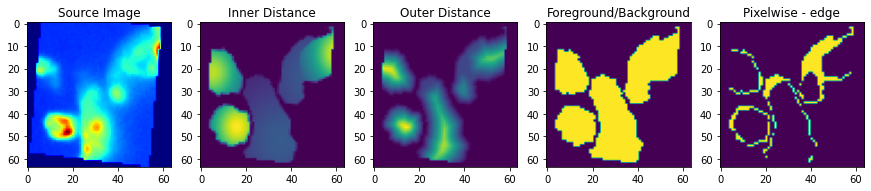

In [32]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

slice=12

axes[0].imshow(img[slice, ..., 0], cmap='jet')
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, slice, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, slice, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, slice, ..., 1])
axes[3].set_title('Foreground/Background')

axes[4].imshow(pixelwise[0, slice, ..., 0])
axes[4].set_title('Pixelwise - edge')

plt.show()

In [33]:
HTML(get_js_video(inputs, batch=0, channel=0, interval=100, cmap='jet'))

## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [34]:
from deepcell.model_zoo.panopticnet import PanopticNet

if frame_shape:
    input_shape = frame_shape
else:
    input_shape = X_train.shape[2:]
    
model = PanopticNet(
    backbone='resnet50',
    input_shape=input_shape,
    frames_per_batch=frames_per_batch, 
    norm_method='std',
    num_semantic_heads=4,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True,
    z_axis_convolutions=z_axis_convolutions)

Using convolutions across the z-axis
Using convolutions across the z-axis
Using convolutions across the z-axis


## Prepare for training

### Set up training parameters.

**n_epoch**: The number of complete passes through the training dataset.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

In [35]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 20 
test_size = .20
optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [36]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [37]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

Call `fit_generator` on the compiled model, along with a default set of callbacks.

In [38]:
# Compensate for cropping by increasing the number of steps per epoch proportionally
cropping_factor = round((X_train.shape[1] / frames_per_batch) * 
                        (X_train.shape[2] / frame_shape[0]) * 
                        (X_train.shape[3] / frame_shape[1]))

print('Cropping factor is {}'.format(cropping_factor))

Cropping factor is 150


In [39]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

num_gpus = count_gpus()
print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=cropping_factor * train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=cropping_factor * val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/20
411/412 [============================>.] - ETA: 0s - loss: 0.1396 - semantic_0_loss: 0.0274 - semantic_1_loss: 0.0996 - semantic_2_loss: 0.0045 - semantic_3_loss: 0.0081
Epoch 00001: val_loss improved from inf to 0.03654, saving model to /deepcell_data/models/mousebrain3D_20x64.h5
412/412 [==============================] - 349s 848ms/step - loss: 0.1393 - semantic_0_loss: 0.0274 - semantic_1_loss: 0.0994 - semantic_2_loss: 0.0045 - semantic_3_loss: 0.0080 - val_loss: 0.0365 - val_semantic_0_loss: 0.0151 - val_semantic_1_loss: 0.0101 - val_semantic_2_loss: 0.0038 - val_semantic_3_loss: 0.0075
Epoch 2/20
411/412 [============================>.] - ETA: 0s - loss: 0.0184 - semantic_0_loss: 0.0065 - semantic_1_loss: 0.0045 - semantic_2_loss: 0.0020 - semantic_3_loss: 0.0054
Epoch 00002: val_loss improved from 0.03654 to 0.01740, saving model to /deepcell_data/models/mousebrain3D_20x64.h5
412/412 [==============================] - 215s 521ms/step - loss: 0.0184

KeyboardInterrupt: 

## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [15]:
# Instantiate prediction model
from deepcell.model_zoo.panopticnet import PanopticNet       
model = PanopticNet(
    backbone='resnet50',
    input_shape=input_shape,
    frames_per_batch=frames_per_batch,
    norm_method='std',
    num_semantic_heads=2,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True,
    z_axis_convolutions=z_axis_convolutions)

Using convolutions across the z-axis
Using convolutions across the z-axis
Using convolutions across the z-axis


In [16]:
# Load weights
model.load_weights(model_path, by_name=True)

In [54]:
def tile_predict_watershed(model,
                           X_test,
                           y_true,
                           input_shape,
                           stride_ratio=0.5,
                           min_distance=10,
                           detection_threshold=0.1,
                           distance_threshold=0.1,
                           small_objects_threshold=0,
                           force_spline=False,
                           spline_power=3,
                           batch_size=1):

    # Tile X_test into overlapping tiles
    X_tiles, tiles_info_X = tile_image_3D(X_test, model_input_shape=input_shape, stride_ratio=stride_ratio)
    
    # Predict on tiles 
    y_pred = model.predict(X_tiles, batch_size=batch_size)

    # Untile predictions
    y_pred = [untile_image_3D(o,
                              tiles_info_X,
                              model_input_shape=input_shape,
                              power=spline_power,
                              force=force_spline) for o in y_pred]
    
    print('shape of y_pred[0] is {}'.format(y_pred[0].shape))
    print('dtypes are {} and {}'.format(y_pred[0].dtype, y_pred[1].dtype))
    print('maxes are {} and {}'.format(np.max(y_pred[0]), np.max(y_pred[1])))
    
    # Run deep_watershed_3D on untiled predictions
    y_pred = deep_watershed_3D(
        y_pred,
        min_distance=min_distance,
        detection_threshold=detection_threshold,
        distance_threshold=distance_threshold,
        exclude_border=False,
        small_objects_threshold=small_objects_threshold)
        
    # Squeeze out channel dimension from y_true
    y_true = np.squeeze(y_true)
    
    # If batch dimension was squeezed out, add it back in
    if y_true.ndim < 4:
        y_true = np.expand_dims(y_true, 0)

    return y_true, y_pred

In [55]:
# Predict on tiles and composite for metrics analysis
input_shape = (frames_per_batch, frame_shape[0], frame_shape[1])
stride_ratio = 0.5  
min_distance = 10             # minimum allowable distance between two centroid coords **
detection_threshold = 0.05    # absolute threshold for minimum peak intensity (centroid detection) **
distance_threshold = 0.01     # outer_distance threshold for cell border **
batch_size = 1
spline_power = 2
force_spline = False

y_true, y_pred = tile_predict_watershed(model=model,
                                        X_test=X_test,
                                        y_true=y_test,
                                        input_shape=input_shape,
                                        stride_ratio=stride_ratio,
                                        min_distance=min_distance,
                                        detection_threshold=detection_threshold,
                                        distance_threshold=distance_threshold,
                                        small_objects_threshold=0,
                                        force_spline=force_spline,
                                        spline_power=spline_power)


print('Shape of y_pred is {} and shape of y_true is {}'.format(y_pred.shape, y_true.shape))

shape of y_pred[0] is (3, 47, 512, 512, 1)
dtypes are float32 and float32
maxes are 1.0041477680206299 and 1.038486123085022
Shape of y_pred is (3, 47, 512, 512) and shape of y_true is (3, 47, 512, 512)


## Run Metrics

In [19]:
from deepcell_toolbox.metrics import Metrics

print('Metrics: no small objects removed')
m = Metrics('DeepWatershed - Remove no pixels', seg=False, ndigits=3, cutoff1=0.5, cutoff2=0.7, is_3d=True, force_event_links=True)
m.calc_object_stats(y_true, y_pred)

Metrics: no small objects removed

____________Object-based statistics____________

Number of true cells:		 260
Number of predicted cells:	 244

Correct detections:  220	Recall: 84.615%
Incorrect detections: 24	Precision: 90.164%

Gained detections: 24	Perc Error: 37.5%
Missed detections: 40	Perc Error: 62.5%
Merges: 0		Perc Error: 0.0%
Splits: 0		Perc Error: 0.0%
Catastrophes: 0		Perc Error: 0.0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.731 



In [20]:
from skimage.morphology import remove_small_objects

small_objects_threshold = 50

# remove small objects - there are some incorrect annotations of very small cells. Should consider removing before training.
for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=small_objects_threshold)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=small_objects_threshold)

    y_pred[i], _, _ = relabel_sequential(y_pred[i])

In [21]:
from deepcell_toolbox.metrics import Metrics

m = Metrics('DeepWatershed - Remove <50', seg=False, ndigits=3, cutoff1=0.5, cutoff2=0.7, is_3d=True)
m.calc_object_stats(y_true, y_pred)


____________Object-based statistics____________

Number of true cells:		 252
Number of predicted cells:	 234

Correct detections:  218	Recall: 86.508%
Incorrect detections: 16	Precision: 93.162%

Gained detections: 16	Perc Error: 32.0%
Missed detections: 34	Perc Error: 68.0%
Merges: 0		Perc Error: 0.0%
Splits: 0		Perc Error: 0.0%
Catastrophes: 0		Perc Error: 0.0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.731 



## Visualize Results














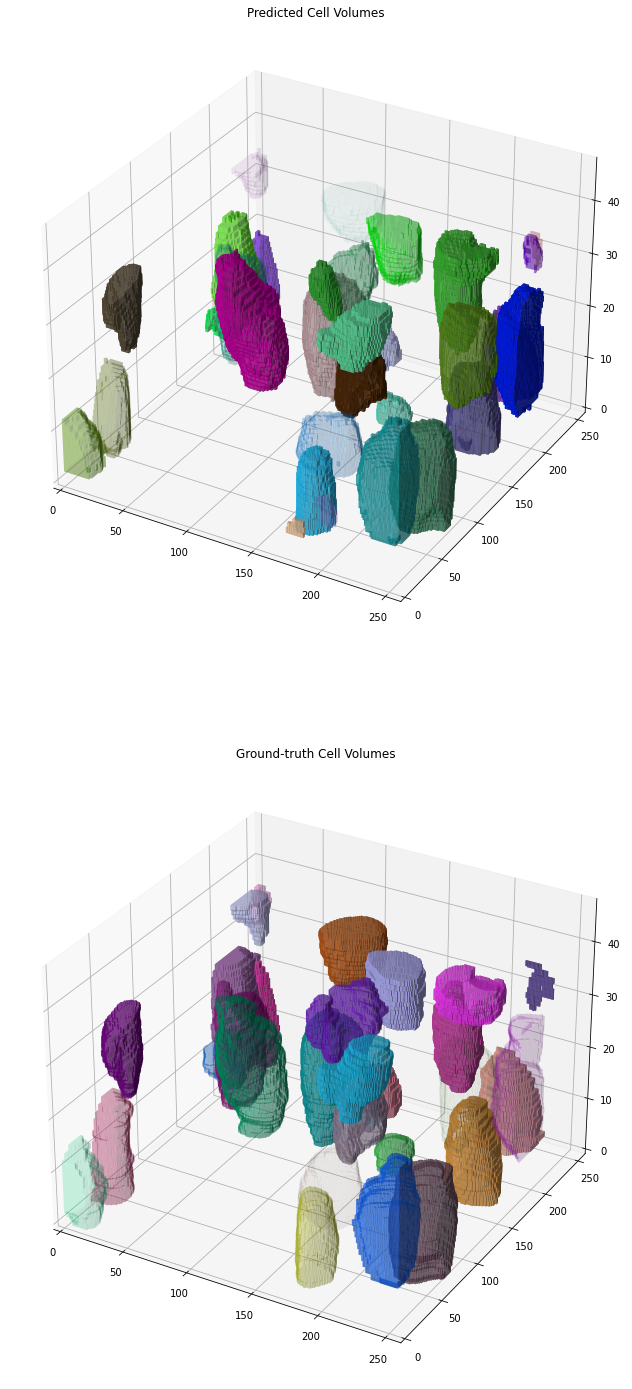

In [23]:
# Plot predicted/true centroids & volumes for one tile 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from skimage.measure import regionprops
#from scipy import ndimage

fig = plt.figure(figsize=(15, 25))
index = 0
x_min = 0
x_max = 256 + x_min
y_min = 0
y_max = 256 + y_min
z_min = 0
z_max = 47 + z_min
masks = y_pred[index, z_min:z_max, x_min:x_max, y_min:y_max]
gt_mask = y_true[index, z_min:z_max, x_min:x_max, y_min:y_max]

# Predicted Cell volumes
ax = fig.add_subplot(211, projection='3d')
ax.set_xlim3d(x_min, x_max)
ax.set_ylim3d(x_min, y_max)
ax.set_zlim3d(z_min, z_max)
plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)
colors = np.empty(plot_masks.shape, dtype='<U9')
color_dict = dict()

for label in np.unique(plot_masks):
    if label != 0:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None#'#7A88CCC0'
    color_dict[label] = color
    colors = np.where(plot_masks==label, color, colors)
ax.voxels(plot_masks, facecolors=colors)
ax.set_title('Predicted Cell Volumes')

# Ground truth Cell Volumes
ax = fig.add_subplot(212, projection='3d')
ax.set_xlim3d(0,x_max)
ax.set_ylim3d(0,y_max)
ax.set_zlim3d(z_min, z_max)
plot_masks = np.rollaxis(np.squeeze(gt_mask), 0, 3)
colors = np.empty(plot_masks.shape, dtype='<U9')
color_dict = dict()

for label in np.unique(plot_masks):
    if label != 0:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None#'#7A88CCC0'
    color_dict[label] = color
    colors = np.where(plot_masks==label, color, colors)

ax.voxels(plot_masks, facecolors=colors)
ax.set_title('Ground-truth Cell Volumes')
plt.show()